# Imports

In [1]:
import numpy as np
import cv2
import glob
import pickle
from scipy import signal

import cProfile
pr = cProfile.Profile()
pr.disable()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# a boatload of helper functions sourced from Udacity module components and Github
from utils import *

%load_ext autoreload
%reload_ext watermark
%watermark -a "Ken Cavagnolo" -n -u -v -m -h -g -p numpy,scipy,cv2

Ken Cavagnolo 
last updated: Sun Mar 26 2017 

CPython 3.5.2
IPython 5.1.0

numpy 1.12.1
scipy 0.19.0
cv2 3.2.0

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.4.0-57-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
host name  : a4430134f7ed
Git hash   :


# Calibration

In [2]:
# Prepare object points
nx, ny = 9, 6

# read cal files
images = glob.glob("camera_cal/calibration*.jpg")

# Generate object points
objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# Initialise image and object point arrays
objpoints = []
imgpoints = []

In [3]:
# loop over cal images
for idx, fname in enumerate(images):

    # Read in image
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        
        # Fill image point and object point arrays
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        write_name = 'output_images/corners_'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)

In [4]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

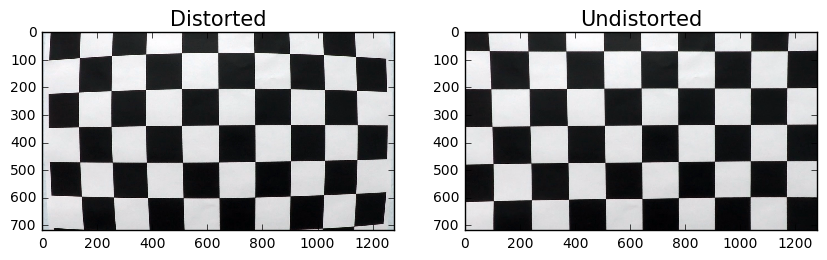

In [5]:
# Save the camera calibration result
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_calibration_result.p", "wb"))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(img)
ax1.set_title('Distorted', fontsize=15)
ax2.imshow(dst)
ax2.set_title('Undistorted', fontsize=15)
write_name = 'output_images/undistorted_calib'+'.jpg'
plt.savefig(write_name)

# Distortion Correction

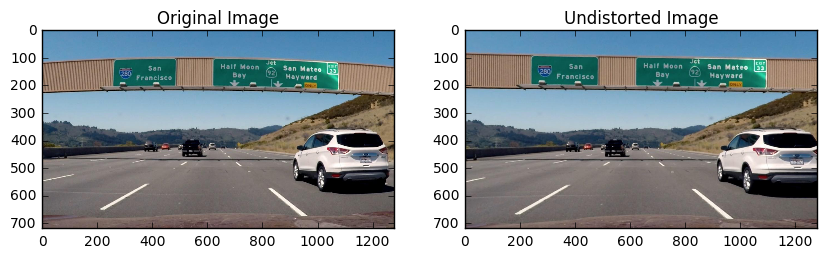

In [6]:
with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

# open data file
raw = cv2.imread("test_images/signs_vehicles.png")
image = cv2.undistort(raw, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(raw[:,:,::-1])
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(image[:,:,::-1])
ax2.set_title('Undistorted Image', fontsize=12)
write_name = 'output_images/undistorted_road'+'.jpg'
plt.savefig(write_name)

# Color Thresholding

In [7]:
%autoreload 2

# open new image
raw = cv2.imread("test_images/test4.jpg")
image = cv2.undistort(raw, mtx, dist, None, mtx)

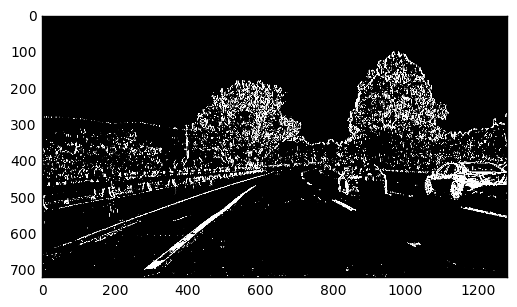

In [8]:
combined_binary = binarize(image,
                           gray_thresh = (20, 255),
                           s_thresh = (170, 255),
                           l_thresh = (30, 255))
plt.imshow(combined_binary, cmap="gray")
write_name = 'output_images/color_thresh'+'.jpg'
plt.savefig(write_name)

# Perspective Transform

In [9]:
corners = np.float32([[253, 697],
                      [585, 456],
                      [700, 456],
                      [1061, 690]])
new_top_left = np.array([corners[0, 0], 0])
new_top_right = np.array([corners[3, 0], 0])
offset = [50, 0]

img_size = (image.shape[1], image.shape[0])
src = np.float32([corners[0], corners[1], corners[2], corners[3]])
dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])

M = cv2.getPerspectiveTransform(src, dst)
M_inverse = cv2.getPerspectiveTransform(dst, src)

cv2.line(image, tuple(corners[0]), tuple(corners[1]), color=[255,0,0], thickness=2);
cv2.line(image, tuple(corners[1]), tuple(corners[2]), color=[255,0,0], thickness=2);
cv2.line(image, tuple(corners[2]), tuple(corners[3]), color=[255,0,0], thickness=2);
cv2.line(image, tuple(corners[3]), tuple(corners[0]), color=[255,0,0], thickness=2);

size = (image.shape[1], image.shape[0])
warped_raw = cv2.warpPerspective(image, M, size, flags=cv2.INTER_LINEAR)
warped = cv2.warpPerspective(combined_binary, M, size, flags=cv2.INTER_LINEAR)

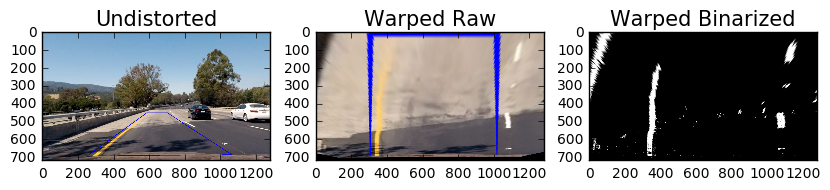

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
ax1.imshow(image[:,:,::-1])
ax1.set_title('Undistorted', fontsize=15)
ax2.imshow(warped_raw[:,:,::-1])
ax2.set_title('Warped Raw', fontsize=15)
ax3.imshow(warped, cmap='gray')
ax3.set_title('Warped Binarized', fontsize=15)
write_name = 'output_images/warped'+'.jpg'
plt.savefig(write_name)

# Detect Lanes

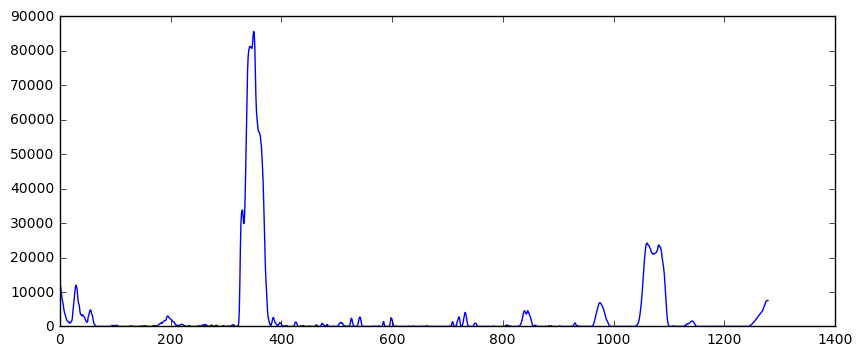

In [11]:
histogram = np.sum(warped[warped.shape[0] // 2:, :], axis=0)
plt.figure(figsize=(10,4))
plt.plot(histogram)
write_name = 'output_images/lane_histo'+'.jpg'
plt.savefig(write_name)

In [12]:
# get midpoint
midpoint = np.int(histogram.shape[0] / 2)

# get left and right halves of the histogram
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print('Peak point of left half: {}'.format(leftx_base))
print('Peak point of right half: {}'.format(rightx_base))

Peak point of left half: 350
Peak point of right half: 1061


In [13]:
nwindows = 12
window_height = np.int(warped.shape[0] / nwindows)

# Extracts x and y coordinates of non-zero pixels
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Set current x coordinated for left and right
leftx_current = leftx_base
rightx_current = rightx_base

margin = 75
min_num_pixels = 35

# save pixel ids in these two lists
left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    win_y_low = warped.shape[0] - (window + 1) * window_height
    win_y_high = warped.shape[0] - window * window_height

    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                      (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                       (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    if len(good_left_inds) > min_num_pixels:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > min_num_pixels:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the ndarrays of indices
left_lane_array = np.concatenate(left_lane_inds)
right_lane_array = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_array]
lefty = nonzeroy[left_lane_array]
rightx = nonzerox[right_lane_array]
righty = nonzeroy[right_lane_array]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

fity = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
fit_leftx = left_fit[0] * fity ** 2 + left_fit[1] * fity + left_fit[2]
fit_rightx = right_fit[0] * fity ** 2 + right_fit[1] * fity + right_fit[2]

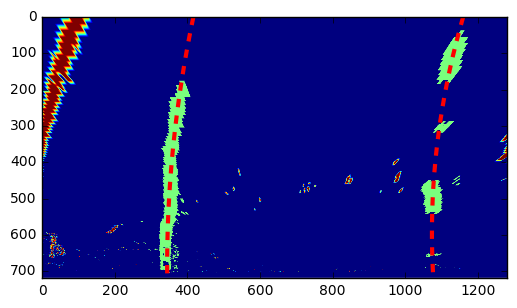

In [14]:
warped[lefty, leftx] = 255/2
warped[righty, rightx] = 255/2

plt.imshow(warped)
lines = plt.plot(fit_leftx, fity, fit_rightx, fity)
plt.setp(lines, linewidth=3, color='r', linestyle='--')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

# Warp Lanes

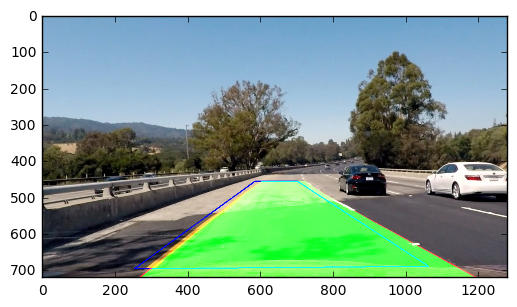

In [22]:
# something to draw on
blank_canvas = np.zeros((720, 1280))
color_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

# Warp the detected lane boundaries back onto the original image.
polyfit_left = draw_poly(blank_canvas, lane_poly, left_fit, 30)
polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_fit, 30)

# Convert to color and highlight lane line area
trace = color_canvas
trace[polyfit_drawn > 1] = [0, 0, 255]
area = highlight_lane_line_area(blank_canvas, left_fit, right_fit)
trace[area == 1] = [0, 255, 0]

# Warp lane boundaries back onto original image
lane_lines = cv2.warpPerspective(trace, M_inverse, size, flags=cv2.INTER_LINEAR)

# Convert to color
combined_img = cv2.add(lane_lines, image)
plt.imshow(combined_img[:,:,::-1])
write_name = 'output_images/lane_labeled'+'.jpg'
plt.savefig(write_name)

# Image Pipeline

In [23]:
%autoreload 2

# Load Distortion Correction
with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

# resolution
ym_per_pix = 30/720
xm_per_pix = 3.7/700

def image_pipeline(file, filepath=False):
    
    # clear plot frame
    plt.clf()
    
    # check and load file
    if filepath == True:
        raw = cv2.imread(file)
    else:
        raw = file

    # Distortion correction
    image = cv2.undistort(raw, mtx, dist, None, mtx)
        
    # Parameters
    size = (image.shape[1], image.shape[0])
    horizontal_offset = 40
    blank_canvas = np.zeros((720, 1280))
    color_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    # Setup Perspective Transform
    corners = np.float32([[253, 697],
                          [585, 456],
                          [700, 456],
                          [1061, 690]])
    new_top_left = np.array([corners[0, 0], 0])
    new_top_right = np.array([corners[3, 0], 0])
    offset = [50, 0]
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
    M = cv2.getPerspectiveTransform(src, dst)
    M_inverse = cv2.getPerspectiveTransform(dst, src)

    # Apply Thresholding
    combined_binary = binarize(image,
                               gray_thresh = (20, 255),
                               s_thresh = (170, 255),
                               l_thresh = (30, 255))
    warped = cv2.warpPerspective(combined_binary, M, size, flags=cv2.INTER_LINEAR)
    left_fit, left_coeffs, right_fit, right_coeffs = fit_lanes(warped)

    # Determine curvature of the lane
    c, mc, ld = road_info(size, left_coeffs, right_coeffs, left_fit, right_fit)
        
    # Warp the detected lane boundaries back onto the original image.
    polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
    polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)

    # Convert to color and highlight lane line area
    trace = color_canvas
    trace[polyfit_drawn > 1] = [0, 0, 255]
    area = highlight_lane_line_area(blank_canvas, left_coeffs, right_coeffs)
    trace[area == 1] = [0,255,0]
    lane_lines = cv2.warpPerspective(trace, M_inverse, size, flags=cv2.INTER_LINEAR)
    combined_img = cv2.add(lane_lines, image)
    add_figures_to_image(combined_img,
                         c=c,
                         v=ld,
                         mc=mc)
    return combined_img

In [24]:
pr.enable()
combined_img = image_pipeline("test_images/test4.jpg", filepath=True)
pr.disable()
pr.print_stats(sort='time')

         2759 function calls (2757 primitive calls) in 0.144 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.031    0.031    0.031    0.031 {undistort}
        1    0.018    0.018    0.036    0.036 utils.py:151(binarize)
        1    0.018    0.018    0.144    0.144 <ipython-input-23-d2b333e4a40b>:13(image_pipeline)
        1    0.016    0.016    0.016    0.016 {imread}
        2    0.014    0.007    0.014    0.007 {warpPerspective}
        1    0.009    0.009    0.009    0.009 {Sobel}
       25    0.007    0.000    0.007    0.000 {method 'nonzero' of 'numpy.ndarray' objects}
        2    0.004    0.002    0.004    0.002 {cvtColor}
        1    0.004    0.004    0.016    0.016 utils.py:204(fit_lanes)
       60    0.003    0.000    0.003    0.000 {line}
       74    0.002    0.000    0.002    0.000 {built-in method numpy.core.multiarray.array}
     1440    0.002    0.000    0.002    0.000 utils.py:108(evaluate

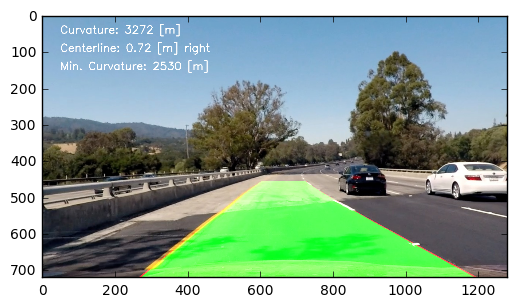

In [25]:
plt.imshow(combined_img[:,:,::-1]);

# Video Pipeline

In [26]:
output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(image_pipeline)
output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [02:54<00:00,  7.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 



In [27]:
%%HTML
<video width="960" height="540" controls>
  <source src="project_output.mp4" type="video/mp4">
</video>

In [ ]:
%autoreload 2
output = 'challenge_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
output_clip = clip1.fl_image(image_pipeline)
output_clip.write_videofile(output, audio=False)

In [ ]:
%%HTML
<video width="960" height="540" controls>
  <source src="challenge_output.mp4" type="video/mp4">
</video>